In [40]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1JIQTVaXv74lwQTr7RL8kahNtMeb0ydAW'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('monkey.png')

file_id = '1O7WDtnFmKZHyvvVBIKo1mG13YQcsAcii'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('kitti.png')

file_id = '1EwGXc6EgOAmM5pu55gacDny5FJMJOj2i'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('imagenet1000_clsidx_to_labels.json')

file_id = '1hcym9dHjvr3JWsdy6DGqO0yzUGT_p9MZ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('coco_clsidx_to_labels.json')

In [1]:
import torch
import cv2
import numpy as np
import json

from torchvision.models import resnet18 as resnet18
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.quantization import resnet18 as resnet18_q
from torchvision import transforms as T

import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

# Классификация (fp32)

## Загрузка/сохранение модели

PyTorch предоставляет набор предобученных моделей. Чтобы ими воспользоваться, достаточно указать pretrained=True, а также перевести в режим eval

In [3]:
classifier = resnet18(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Веса хранятся в state_dict в виде словаря

In [4]:
sd = classifier.state_dict()
sd.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

Веса можно сохранить на диск. Как правило, такая операция производится в процессе обучения - checkpoints

In [5]:
torch.save(classifier.state_dict(), 'resnet18.pth')

Сохраненные таким образом веса можно загрузить в модель

In [6]:
sd = torch.load('resnet18.pth')
classifier.load_state_dict(sd)

<All keys matched successfully>

## Исследование архитектуры

### Текстовое представление и доступ к блокам

Архитектуру модели можно легко визуализировать в тектовом виде

In [7]:
classifier

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Доступ к отдельным блокам/слоям модели осуществляется по имени/индексу

In [8]:
classifier.layer1[1]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
classifier.layer1[1].conv1

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

Свертоный слой содержит тензор весов, который при сохранении на диск имеет ключ layer1.1.conv1.weight

In [10]:
classifier.layer1[1].conv1.weight.shape

torch.Size([64, 64, 3, 3])

### ONNX и Netron

Для визуализации архитектуры модели можно экспортировать её в формате [ONNX](https://onnx.ai/) и визуализировать в [Netron](https://netron.app/)

In [11]:
torch.onnx.export(classifier, torch.randn(1, 3, 224, 224), 'resnet18.onnx')

![](https://drive.google.com/uc?export=view&id=1gIm7h5l5tpbzTRzkzvUmC8-n8gPXtpqg)

## Считывание и подготовка входных данных

In [16]:
IMAGE_PATH = 'monkey.png'

OpenCV часто используется для обработки изображений, есть интерфейсы для python и C++.

In [17]:
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV повсеместно использует BGR формат представления цвета

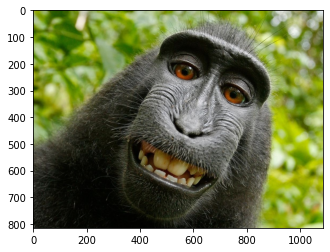

In [18]:
plt.imshow(image)

In [19]:
image.shape

(814, 1085, 3)

In [20]:
h, w = image.shape[:2]

Модель была обучена на изображениях 224x224, поэтому предобразуем входное изображение к такому формату

In [21]:
image = image[:, (w - h) // 2:(w - h) // 2 + h]  # center crop

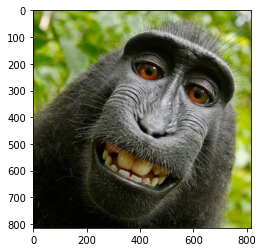

In [22]:
plt.imshow(image)

In [23]:
image = cv2.resize(image, (224, 224))

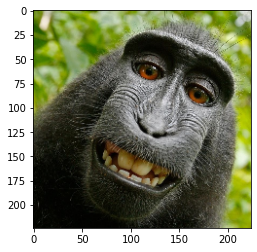

In [24]:
plt.imshow(image)

Изначально изображение содержит величины интенсивности компонент RGB в диапазоне 0..255. Модели, как правило, принимают на вход нормализованные данные в виде чисел с плавающей точкой:

In [25]:
image_tensor = torch.Tensor(image).float() / 255  # переводим в диапазон 0..1

In [26]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

image_tensor = (image_tensor - mean) / std  # делаем нормализацию

In [27]:
image_tensor.shape

torch.Size([224, 224, 3])

В PyTorch принято, что канал цвета задан первой размерностью, а не последней

In [28]:
image_tensor = image_tensor.permute(2, 0, 1)

In [29]:
image_tensor.shape

torch.Size([3, 224, 224])

Модели обрабатывают данные в виде батчей - наборов нескольких изображений

In [30]:
batch = image_tensor.unsqueeze(0)

In [31]:
batch.shape

torch.Size([1, 3, 224, 224])

In [32]:
if torch.cuda.is_available():
    batch = batch.cuda()

if torch.cuda.is_available():
    classifier = classifier.cuda()

Произведем измерение скорости инференса. Обратите внимание на torch.cuda.synchronize(). CUDA операции выполняются асинхронно, то есть когда выполняется команда logits = classifier(batch), то процесс вычислений ставится в очередь, а не начинает выполняться незамедлительно. Кроме того, выход из этой операции не гарантирует завершение процесса вычислений. Однако, после синхронизации, все вычисления, поставленные в очередь до нее гарантированно завершаются.

In [34]:
%%timeit
with torch.no_grad():
    logits = classifier(batch)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

100 loops, best of 5: 9.23 ms per loop


In [35]:
with torch.no_grad():
    logits = classifier(batch)

Для получения вероятностей классов применим softmax

In [36]:
probs = torch.softmax(logits, 1)

Выберем топ-5 классов, в которых уверена модель

In [37]:
topk = torch.topk(logits, 5)

In [38]:
topk

torch.return_types.topk(values=tensor([[13.2837, 12.4374, 11.4100, 11.0296, 10.8568]], device='cuda:0'), indices=tensor([[370, 369, 366, 368, 367]], device='cuda:0'))

In [41]:
with open('imagenet1000_clsidx_to_labels.json', 'r') as f:
    imagenet1k_clsidx_to_labels = json.load(f)

In [42]:
for v in topk.indices[0]:
    print(imagenet1k_clsidx_to_labels[v])

guenon
siamang
gorilla
gibbon
chimpanzee


In [51]:
batch = batch.cpu()
classifier = classifier.cpu()

In [52]:
%%timeit
with torch.no_grad():
    logits = classifier(batch)

10 loops, best of 5: 84.8 ms per loop


## Классификация (int8)

Модели могут выполняться не с использованием float point 32, а с использованием чисел меньшей разрядности. Это позволяет уменьшить энергопотребление и увеличить скорость работы

In [43]:
classifier_q = resnet18_q(pretrained=True, quantize=True).eval()

Downloading: "https://download.pytorch.org/models/quantized/resnet18_fbgemm_16fa66dd.pth" to /root/.cache/torch/hub/checkpoints/resnet18_fbgemm_16fa66dd.pth


  0%|          | 0.00/11.2M [00:00<?, ?B/s]

In [44]:
batch = batch.cpu()

In [46]:
%%timeit
with torch.no_grad():
    logits = classifier_q(batch)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

10 loops, best of 5: 59.9 ms per loop


In [47]:
with torch.no_grad():
    logits = classifier_q(batch)

In [48]:
topk = torch.topk(logits, 5)

In [49]:
topk

torch.return_types.topk(values=tensor([[13.1066, 12.5368, 11.6820, 11.1122, 11.1122]]), indices=tensor([[370, 369, 366, 368, 367]]))

In [50]:
for v in topk.indices[0]:
    print(imagenet1k_clsidx_to_labels[v])

guenon
siamang
gorilla
gibbon
chimpanzee


# Семантическая сегментация

In [53]:
segmentator = fcn_resnet50(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

In [54]:
if torch.cuda.is_available():
    segmentator = segmentator.cuda()

In [57]:
image = cv2.imread('kitti.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

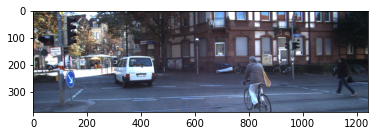

In [58]:
plt.imshow(image)

In [59]:
image_tensor = torch.Tensor(image).float() / 255

In [60]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

image_tensor = (image_tensor - mean) / std

In [61]:
image_tensor = image_tensor.permute(2, 0, 1)

In [62]:
batch = image_tensor.unsqueeze(0)

In [63]:
if torch.cuda.is_available():
    batch = batch.cuda()

In [65]:
%%timeit
with torch.no_grad():
    logits = segmentator(batch)
    if torch.cuda.is_available():
        torch.cuda.synchronize()

1 loop, best of 5: 359 ms per loop


In [66]:
with torch.no_grad():
    logits = segmentator(batch)

In [67]:
probs = torch.softmax(logits['aux'][0], 0)

In [68]:
with open('coco_clsidx_to_labels.json', 'r') as f:
    coco_clsidx_to_labels = json.load(f)

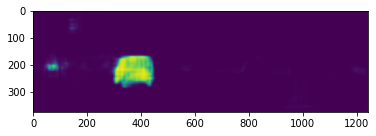

In [69]:
plt.imshow(probs.cpu()[coco_clsidx_to_labels.index('car')])

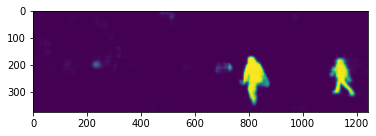

In [70]:
plt.imshow(probs.cpu()[coco_clsidx_to_labels.index('person')])

In [71]:
classes = probs.argmax(dim=0) * (probs.max(dim=0).values > 0.5)

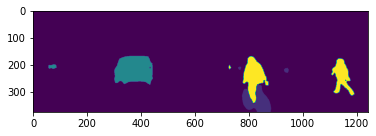

In [72]:
plt.imshow(classes.cpu())

In [73]:
rgb_pallete = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 255],  # bicycle
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [255, 0, 0],  # car
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 255, 0],  # person
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
])

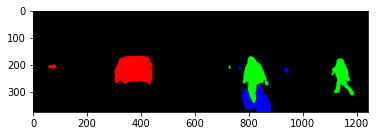

In [74]:
plt.imshow(rgb_pallete[classes.cpu()])